In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#library yang digunakan
import cv2 
import os 
from google.colab.patches import cv2_imshow 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import random

# Load data

In [ ]:
# File dataset ada di Shared drives pada Google Drive
path = "/content/drive/Shareddrives/flowers"
kelas = ['daisy', 'dandelion', 'sunflower'] #kelas/category

#load file names
data = []
dataLabel = []
for category in kelas:
  flower_folder = os.path.join(path, category)
  file_names = os.listdir(flower_folder)
  full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
  data.append(full_path)
  for citra in file_names:
      full_path = os.path.join(flower_folder, citra)
      if category == 'daisy':
        label =  0
      elif category == 'dandelion':
        label =  1
      elif category == 'sunflower':
        label = 2
      dataLabel.append(label)

In [ ]:
#load images dan mengubahnya menjadi grayscale
dim = (320, 240)
images = []
resized_images = []
for names in data:
  one_category_images = [cv2.imread(name,0) for name in names]
  images.append(one_category_images)
  for i in range(len(one_category_images)):
        res = cv2.resize(one_category_images[i], dim, interpolation=cv2.INTER_LINEAR)
        resized_images.append(res)


## visualisasi

contoh citra setiap kelas


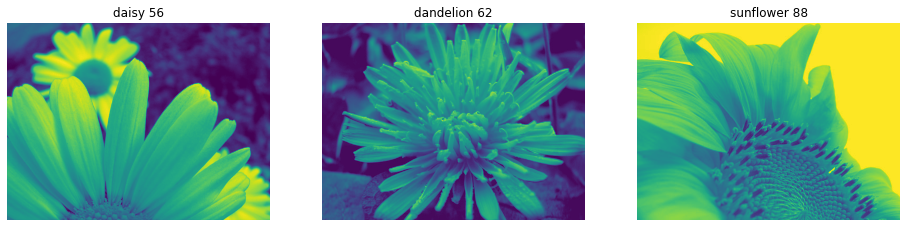

In [ ]:
#visualisasi contoh data

print("contoh citra setiap kelas")
index = []
plt.figure(figsize=(16,12))
for i, imgs in enumerate(images):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    idx = np.random.randint(len(imgs))
    plt.imshow(imgs[idx])
    plt.title(kelas[i]+' '+str(idx))
    index.append(idx)
plt.show()

contoh citra setiap kelas dalam grayscale setelah resized


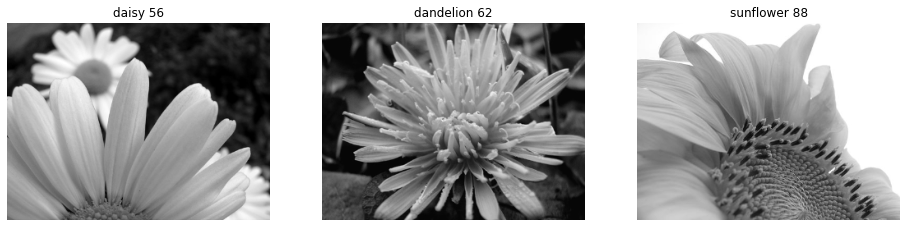

In [ ]:
print("contoh citra setiap kelas dalam grayscale setelah resized")
plt.figure(figsize=(16,12))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.axis('off')
  plt.title(kelas[i]+' '+str(index[i]))
  plt.imshow(resized_images[i*100+index[i]], cmap='gray')
plt.show()

In [ ]:
#normalize
def normalize(citra):
  return np.array(citra)/255.

In [ ]:
#flatten
flatImg=[]
for img in resized_images:
  flatImg.append(normalize(img).flatten())

flatImg[1]

array([0.11372549, 0.10980392, 0.11372549, ..., 0.17647059, 0.18039216,
       0.18431373])

# Backpropagation

In [ ]:
#e. fungsi aktivasi dengan sigmoid 
def activation(z):
  return 1 / (1 + np.exp(-z))

In [ ]:
#g. MLP- menghitung error
def error(actual, predicted):
  return 1/2*(predicted - actual)**2

In [ ]:
from random import random
#f. MLP- inisialisasi bobot bias
def inisialisasi(nInput, nHidden, nOut):
  net = []
  hiddenlayer = [{'w':[random() for i in range(nInput + 1)]} for i in range(nHidden)]
  outputlayer = [{'w':[random() for i in range(nHidden + 1)]} for i in range(nOut)]
  net.append(hiddenlayer)
  net.append(outputlayer)
  return net

In [ ]:
#h. MLP- feedforward
def result(weight, theta):
  result = weight[-1]
  for i in range(len(weight)-1):
    result += weight[i] * theta[i]
  return result
  
def feedforward(net, pix):
  inputs = pix
  for layer in net:
    nextinput = []
    for n in layer:
      hsl = result(n['w'], inputs)
      n['out'] = activation(hsl)
      nextinput.append(n['out'])

    inputs = nextinput
  return inputs

In [ ]:
#i. MLP- update bobot backward
def delta(output):
  return output*(1.0-output)
  
def backward(network, target):
  for i in reversed(range(len(network))):
    layer = network[i]
    errors = []
  #hidden to input
    if i != len(network)-1:
      for j in range(len(layer)):
        e = 0.0
        for n in network[i+1]:
          e += (n['w'][j]*n['delta'])
          errors.append(e)
    #output to hidden
    else:
      for j in range(len(layer)):
        n = layer [j]
        errors.append(target[j]-n['out'])
    for j in range(len(layer)):
      n = layer[j]
      n['delta'] = errors[j]*delta(n['out'])

def update_weight(network, theta, lr):
  for i in range(len(network)):
    inputs = theta[:-1] if i==0 else [n['out'] for n in network[i-1]]
    for n in network[i]:
      for j in range(len(inputs)):
        n['w'][j] = n['w'][j] + lr*n['delta']*inputs[j]
      n['w'][-1] = n['w'][-1] + lr*n['delta']

In [ ]:
#j. MLP- prediksi (cross entropy)
def prediction(activation):
  output=[]
  Nilaimax = max(activation)
  for i in range(len(activation)):
    if activation[i] == Nilaimax:
      prediction = 1
    else: 
      prediction = 0
    output.append(prediction)
  return output

# prediction([0.9,0.8,0.1])

In [ ]:
#k. MLP- fungsi akurasi
def accuracy_function(actual, predicted):
  correct = 0
  for i in range(len(actual)):
    if actual[1] == predicted[i]:
      correct += 1
  return correct/float(len(actual))

# Training

In [ ]:
def train_network(dataset, label, network, lr, epoch, n_out):
  err = []
  acc = []
  for ep in range(epoch):
    correct = 0.0
    sumerror = 0.0

    for citra in range(len(dataset)):
      data = dataset[citra]
      outputs = feedforward(network, data)
      expected = [0 for i in range(n_out)]

      #   #membuat one hot encoding
      expected[label[citra]] = 1
      sumerror += sum([error(expected[i], outputs[i]) for i in range (len(expected))])
      backward(network, expected)
      update_weight(network, data, lr)
      
      #   prediksi dari hasil aktivasi
      outputs= prediction(outputs)

      # print(expected, outputs)
      if expected == outputs:
        correct = correct + 1.0
      
    err.append(sumerror/len(dataset))
    acc.append(correct/len(dataset))
    print(ep+1, "\t", "Loss: ", err[-1], "\t| accuracy: ", acc[-1])
  return err, acc, network

In [ ]:
def test_network(dataset, label, network, lr, epoch, n_out):
  err = []
  acc=[]
  for ep in range(epoch):
    correct = 0.0
    sumerror = 0.0
    
    for citra in range(len(dataset)):
      data = dataset[citra]
      outputs = feedforward(network, data)
      expected = [0 for i in range(n_out)]

      #   #membuat one hot encoding
      expected[label[citra]] = 1
      sumerror += sum([error(expected[i], outputs[i]) for i in range (len(expected))])
      backward(network, expected)
      update_weight(network, data, lr)

      #   prediksi dari hasil aktivasi
      outputs= prediction(outputs)

      # print(expected, outputs)
      if expected == outputs:
        correct = correct + 1.0

    err.append(sumerror/len(dataset))
    acc.append(correct/len(dataset))      
    print(ep+1, "\t", "test_loss: ", err[-1], "\t| test_accuracy: ", acc[-1])
  return err, acc, network

In [ ]:
from sklearn.model_selection import train_test_split
#l. MLP - mendefinisikan fungsi untuk training (80%) dan testing (20%)

X_train, X_test, Y_train, Y_test  = train_test_split(flatImg, dataLabel,train_size=0.8, random_state = 1 )

lenTrainImage= len(X_train)
print("jumlah citra training : ",lenTrainImage)
lenTestImage= len(X_test)
print("jumlah citra test : ",lenTestImage)

jumlah citra training :  240
jumlah citra test :  60


In [ ]:
#learning rate 0.1
n_inputs = len(X_train[0])-1
n_outputs = 3
network = inisialisasi(n_inputs, 1, n_outputs)
train_arr1, train_error1, train_network1 = train_network(X_train, Y_train,network, 0.1, 50, n_outputs)

1 	 Loss:  0.38280043030207195 	| accuracy:  0.30833333333333335
2 	 Loss:  0.33648614574224933 	| accuracy:  0.30416666666666664
3 	 Loss:  0.3362745869274035 	| accuracy:  0.2833333333333333
4 	 Loss:  0.3362730404919401 	| accuracy:  0.2833333333333333
5 	 Loss:  0.3362730403725834 	| accuracy:  0.2833333333333333
6 	 Loss:  0.33627304141892467 	| accuracy:  0.2833333333333333
7 	 Loss:  0.33627304149572684 	| accuracy:  0.2833333333333333
8 	 Loss:  0.3362730414988884 	| accuracy:  0.2833333333333333
9 	 Loss:  0.3362730414986921 	| accuracy:  0.2833333333333333
10 	 Loss:  0.33627304149861725 	| accuracy:  0.2833333333333333
11 	 Loss:  0.336273041498604 	| accuracy:  0.2833333333333333
12 	 Loss:  0.33627304149860165 	| accuracy:  0.2833333333333333
13 	 Loss:  0.3362730414986018 	| accuracy:  0.2833333333333333
14 	 Loss:  0.33627304149860154 	| accuracy:  0.2833333333333333
15 	 Loss:  0.3362730414986016 	| accuracy:  0.2833333333333333
16 	 Loss:  0.3362730414986016 	| accurac

In [ ]:
print("epoch\t\tloss\t\t\t\taccuracy")
test_arr1, test_error1, test_network1 = test_network(X_test, Y_test,network, 0.1, 50, n_outputs)

epoch		loss				accuracy
1 	 test_loss:  0.3364151922946886 	| test_accuracy:  0.26666666666666666
2 	 test_loss:  0.33621536965915383 	| test_accuracy:  0.2
3 	 test_loss:  0.336160691857455 	| test_accuracy:  0.23333333333333334
4 	 test_loss:  0.33614701743270103 	| test_accuracy:  0.25
5 	 test_loss:  0.3361442969430739 	| test_accuracy:  0.25
6 	 test_loss:  0.33614415428549216 	| test_accuracy:  0.25
7 	 test_loss:  0.3361444249330368 	| test_accuracy:  0.25
8 	 test_loss:  0.33614464334968885 	| test_accuracy:  0.25
9 	 test_loss:  0.33614476346169375 	| test_accuracy:  0.25
10 	 test_loss:  0.3361448174032884 	| test_accuracy:  0.25
11 	 test_loss:  0.33614483650545485 	| test_accuracy:  0.25
12 	 test_loss:  0.33614483991064686 	| test_accuracy:  0.25
13 	 test_loss:  0.3361448374334016 	| test_accuracy:  0.25
14 	 test_loss:  0.3361448335156531 	| test_accuracy:  0.25
15 	 test_loss:  0.33614482989102307 	| test_accuracy:  0.25
16 	 test_loss:  0.33614482706107285 	| test_accu

In [ ]:
#learning rate 0.8
n_inputs = len(X_train[0])-1
n_outputs = 3
network = inisialisasi(n_inputs, 1, n_outputs)
train_arr2, train_error2, train_network2 = train_network(X_train, Y_train,network, 0.8, 50, n_outputs)

1 	 Loss:  0.355688644157482 	| accuracy:  0.3125
2 	 Loss:  0.349606731200821 	| accuracy:  0.3125
3 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
4 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
5 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
6 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
7 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
8 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
9 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
10 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
11 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
12 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
13 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
14 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
15 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
16 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
17 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
18 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
19 	 Loss:  0.3496067311949742 	| accuracy:  0.3125
20 	 Loss:  0.349606731

In [ ]:
print("epoch\t\tloss\t\t\t\taccuracy")
test_arr2, test_error2, test_network2 = test_network(X_test, Y_test, network, 0.8, 50, n_outputs)

epoch		loss				accuracy
1 	 test_loss:  0.3533837744545592 	| test_accuracy:  0.2
2 	 test_loss:  0.3504925313123405 	| test_accuracy:  0.23333333333333334
3 	 test_loss:  0.3504558579388706 	| test_accuracy:  0.23333333333333334
4 	 test_loss:  0.3504553350227041 	| test_accuracy:  0.23333333333333334
5 	 test_loss:  0.3504553274622349 	| test_accuracy:  0.23333333333333334
6 	 test_loss:  0.35045532735195056 	| test_accuracy:  0.23333333333333334
7 	 test_loss:  0.3504553273503316 	| test_accuracy:  0.23333333333333334
8 	 test_loss:  0.3504553273503076 	| test_accuracy:  0.23333333333333334
9 	 test_loss:  0.35045532735030727 	| test_accuracy:  0.23333333333333334
10 	 test_loss:  0.35045532735030727 	| test_accuracy:  0.23333333333333334
11 	 test_loss:  0.35045532735030727 	| test_accuracy:  0.23333333333333334
12 	 test_loss:  0.35045532735030727 	| test_accuracy:  0.23333333333333334
13 	 test_loss:  0.35045532735030727 	| test_accuracy:  0.23333333333333334
14 	 test_loss:  0.3

# Visualisasi Error dan Akurasi

## Learning rate 0.1

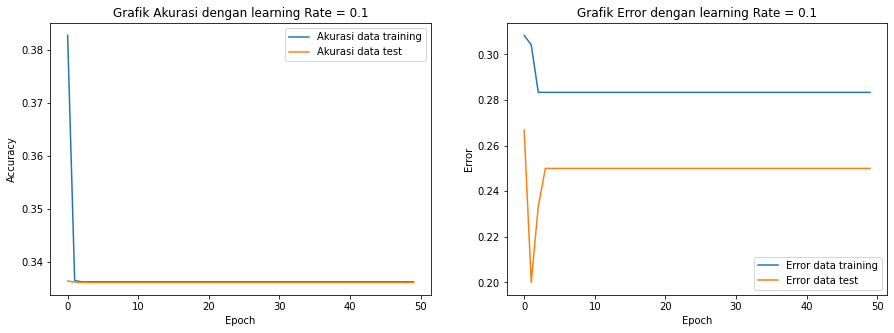

In [ ]:
# Visualisasikan akurasi setiap 50 epoch, learning rate = 0.1
epoch = range(50)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(epoch, train_arr1, label="Akurasi data training")
plt.plot(epoch, test_arr1, label="Akurasi data test")
plt.title("Grafik Akurasi dengan learning Rate = 0.1")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')

# ========================================================
# Visualisasikan error setiap 50 epoch, learning rate = 0.1

plt.subplot(1,2,2)
plt.plot(epoch, train_error1, label="Error data training")
plt.plot(epoch, test_error1, label="Error data test")
plt.title("Grafik Error dengan learning Rate = 0.1")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(loc='lower right')

## Learning rate 0.8

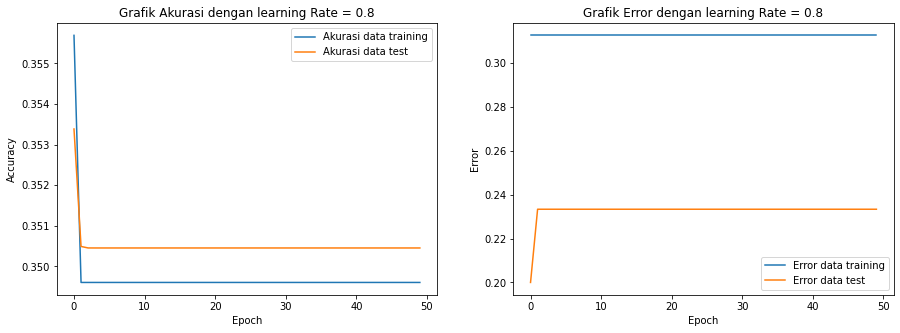

In [ ]:
# Visualisasikan akurasi setiap 50 epoch, learning rate = 0.8

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(epoch, train_arr2, label="Akurasi data training")
plt.plot(epoch, test_arr2, label="Akurasi data test")
plt.title("Grafik Akurasi dengan learning Rate = 0.8")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')

# ========================================================
# Visualisasikan error setiap 50 epoch, learning rate = 0.8

plt.subplot(1,2,2)
plt.plot(epoch, train_error2, label="Error data training")
plt.plot(epoch, test_error2, label="Error data test")
plt.title("Grafik Error dengan learning Rate = 0.8")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(loc='lower right')